In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


In [2]:

# loading package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV





In [3]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_data = df_train.append(df_test)
#submit = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# 查看data資料是否有缺失

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 資料分析(EDA)

,Sex,Survived
0,female,0.742
1,male,0.189


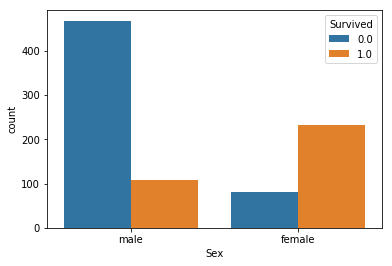

In [6]:
# Male to female survival ratio
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
display(df_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(3))

# class

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


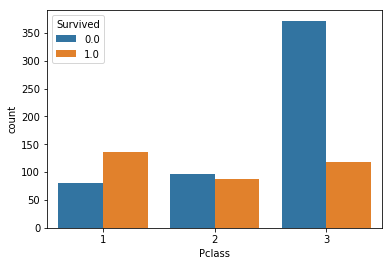

In [7]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)


# 將男女資料轉為1,0

In [8]:
# Convert Sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

In [9]:
# Split training set the testing set
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [10]:
# Input set and labels
X = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = df_train['Survived']

# 先用性別跟票倉來跑一次預測

In [11]:
# Show Baseline
Base = ['Sex_Code', 'Pclass']
Base_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.73176


# 利用測試資料預測

In [12]:
# submission if you want
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

Base_pred = Base_Model.predict(X_Submit[Base])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":Base_pred.astype(int)})
submit.to_csv("submit_Base.csv",index=False)

# 另一種作法，利用特徵處理自動過濾特徵

In [13]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import xgboost
from xgboost import XGBClassifier


# one-hot encoding

In [14]:
df_data = pd.get_dummies(df_data) 

In [15]:
# Split training set the testing set
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

# Input set and labels
X = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = df_train['Survived']

In [16]:
X

,Age,Fare,Parch,Pclass,SibSp,Sex_Code,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,...,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
0,22.0,7.2500,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,71.2833,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,35.0,53.1000,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35.0,8.0500,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887,19.0,30.0000,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
888,NaN,23.4500,2,3,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
889,26.0,30.0000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 將訓練集切割作為訓練和驗證

In [17]:
X_train, X_eval, Y_train, Y_eval = train_test_split(X, Y, test_size=0.3, random_state=42)

In [18]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

finally_step = ('model', RandomForestClassifier(random_state=2,n_estimators=1000,min_samples_split=20,oob_score=True))

pipeline = Pipeline(steps=[step1, step2, step3, finally_step])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
pipeline.fit(X, Y)

Pipeline(memory=None,
         steps=[('Imputer',
                 Imputer(axis=0, copy=True, missing_values='NaN',
                         strategy='mean', verbose=0)),
                ('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('FeatureSelection', VarianceThreshold(threshold=0.0)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=20,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10

# Train score

In [20]:
print(f"Train score: {pipeline.score(X_train, Y_train)}")

Train score: 0.9823434991974318


In [21]:
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

Y_pred = pipeline.predict(X_train)
VARIANCE_SCORE = metrics.explained_variance_score(Y_train, Y_pred)
MSLE = np.sqrt(metrics.mean_squared_error(Y_train, Y_pred))
r2 = metrics.r2_score(Y_train, Y_pred)

print("MSLE = ", MSLE)
#print("RMSLE = ", RMSLE)
print("VARIANCE_SCORE = ", VARIANCE_SCORE)
print("R2", r2)


MSLE =  0.13287776639667082
VARIANCE_SCORE =  0.9244191182966693
R2 0.9243197278911565


In [22]:
scores = cross_val_score(pipeline, X, Y, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Accuracy: 0.81 (+/- 0.02)


In [23]:
# submits

X_Submit = df_test.drop(labels=['Survived', 'PassengerId'],axis=1)

pred = pipeline.predict(X_Submit)

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":pred.astype(int)})
submit.to_csv("submit_final.csv",index=False)

